# Joanie's modelling notebook

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
import pandas as pd
import statsmodels.api as sm 

## Reading in data and some light EDA

In [2]:
x = {1,2,3}
set(str(x))

{' ', ',', '1', '2', '3', '{', '}'}

In [3]:
## Reading in the data

train = pd.read_csv("../data/broadband_training_2.csv", converters={'All_Providers' : lambda x: x.replace("{","").replace("}", "").split(", ")})
test = pd.read_csv("../data/broadband_test_2.csv", converters={'All_Providers' : lambda x: x.replace("{","").replace("}", "").split(", ")})

In [4]:
## Add additional columns for incomes

train['pct_pop_income_lt_50k'] = (train['pct_pop_lt_10k'] + train['pct_pop_10k_thru_15k'] +
                                  train['pct_pop_15k_thru_20k'] + train['pct_pop_20k_thru_25k'] + 
                                  train['pct_pop_25k_thru_30k'] + train['pct_pop_30k_thru_35k'] +
                                  train['pct_pop_35k_thru_40k'] + train['pct_pop_40k_thru_45k'] +
                                  train['pct_pop_45k_thru_50k']
                                 )

train['pct_pop_income_lt_30k'] = (train['pct_pop_lt_10k'] + train['pct_pop_10k_thru_15k'] +
                                  train['pct_pop_15k_thru_20k'] + train['pct_pop_20k_thru_25k'] + 
                                  train['pct_pop_25k_thru_30k']
                                 )

train['pct_pop_income_gt_100k'] = (train['pct_pop_100k_thru_125k'] + train['pct_pop_125k_thru_150k'] +
                                   train['pct_pop_150k_thru_200k'] + train['pct_pop_gt_200k']
                                 )

test['pct_pop_income_lt_50k'] = (test['pct_pop_lt_10k'] + test['pct_pop_10k_thru_15k'] +
                                  test['pct_pop_15k_thru_20k'] + test['pct_pop_20k_thru_25k'] + 
                                  test['pct_pop_25k_thru_30k'] + test['pct_pop_30k_thru_35k'] +
                                  test['pct_pop_35k_thru_40k'] + test['pct_pop_40k_thru_45k'] +
                                  test['pct_pop_45k_thru_50k']
                                 )

test['pct_pop_income_lt_30k'] = (test['pct_pop_lt_10k'] + test['pct_pop_10k_thru_15k'] +
                                  test['pct_pop_15k_thru_20k'] + test['pct_pop_20k_thru_25k'] + 
                                  test['pct_pop_25k_thru_30k']
                                 )

test['pct_pop_income_gt_100k'] = (test['pct_pop_100k_thru_125k'] + test['pct_pop_125k_thru_150k'] +
                                   test['pct_pop_150k_thru_200k'] + test['pct_pop_gt_200k']
                                 )

train['log_median_income'] = np.log(train['median_income'])
test['log_median_income'] = np.log(test['median_income'])

In [5]:
## Additional age buckets


train["pct_ages_gt_50"] = (train['pct_pop_50_to_54'] + train['pct_pop_55_to_59'] + train['pct_pop_60_to_64'] +
                           train['pct_pop_65_to_69'] + train['pct_pop_70_to_74'] + train['pct_pop_75_to_79'] + 
                           train['pct_pop_80_to_84'] + train['pct_pop_gt_85']
                                     )

train["pct_ages_lt_9"] = (train['pct_pop_lt_5'] + train['pct_pop_5_to_9'])


test["pct_ages_gt_50"] = (test['pct_pop_50_to_54'] + test['pct_pop_55_to_59'] + test['pct_pop_60_to_64'] +
                           test['pct_pop_65_to_69'] + test['pct_pop_70_to_74'] + test['pct_pop_75_to_79'] + 
                           test['pct_pop_80_to_84'] + test['pct_pop_gt_85']
                                     )

test["pct_ages_lt_9"] = (test['pct_pop_lt_5'] + test['pct_pop_5_to_9'])

In [105]:
## Trying some interaction terms

train['interaction_computer_internet'] = train['pct_computer'] * train['pct_internet']
test['interaction_computer_internet'] = test['pct_computer'] * test['pct_internet']

train['interaction_low_income_internet'] = train['pct_pop_income_lt_50k'] * train['pct_internet']
test['interaction_low_income_internet'] = test['pct_pop_income_lt_50k'] * test['pct_internet']

train['interaction_high_income_internet'] = train['pct_pop_income_gt_100k'] * train['pct_internet']
test['interaction_high_income_internet'] = test['pct_pop_income_gt_100k'] * test['pct_internet']

train['interaction_white_internet'] = train['pct_white'] * train['pct_internet']
test['interaction_white_internet'] = test['pct_white'] * test['pct_internet']

train['interaction_hisp_internet'] = train['pct_hisp_latino'] * train['pct_internet']
test['interaction_hisp_internet'] = test['pct_hisp_latino'] * test['pct_internet']

In [7]:
## Additional columns for big CA providers
## Based on fastest providers from: https://broadbandnow.com/California
## What's Spectrum's business name?
fcc_names = pd.read_csv("../data/fcc_names.csv")
fcc_names[fcc_names.DBAName.str.contains("Comcast")]


,Provider_Id,ProviderName,DBAName
1114,55574,"COMCAST CABLE COMMUNICATIONS, LLC",Comcast


In [8]:
def check_for_att(row):
    if len(row) > 0:
        for i in row:
            #print(i)
            if int(i) > 67052:
                return True
    return False

In [9]:
train["All_Providers"].head()

0    [56004, 54694, 59246, 55027, 59349, 55574, 55262]
1    [58561, 55394, 56004, 56741, 54694, 59475, 568...
2    [55394, 58883, 56004, 54694, 54860, 67058, 593...
3    [56448, 59520, 58623, 56004, 54694, 55084, 562...
4    [56448, 55394, 56004, 54076, 54694, 54860, 548...
Name: All_Providers, dtype: object

In [10]:
## Test if providers contains a provider > 67052 (i.e. ATT company)

train["Comcast_present"] = train["All_Providers"].apply(lambda row: '55574' in row)

test["Comcast_present"] = test["All_Providers"].apply(lambda row: '55574' in row)

train["ATT_present"] = train["All_Providers"].apply(check_for_att)

test["ATT_present"] = test["All_Providers"].apply(check_for_att)

In [16]:
## Bools for presence of a wired provider > 100 download

train["Wired_100_Bool"] = train["Wired_Provider_Count_100"].apply(lambda row: int(row) > 0)
test["Wired_100_Bool"] = test["Wired_Provider_Count_100"].apply(lambda row: int(row) > 0)

In [17]:
pd.set_option('display.max_rows', None)
train.columns.to_list()

['tract_geoid',
 'All_Provider_Count',
 'All_Providers',
 'MaxAdDown',
 'MaxAdUp',
 'AllMaxAdDown',
 'AllMaxAdUp',
 'Wired_Provider_Count',
 'Satellite_Provider_Count',
 'Fixed_Wireless_Provider_Count',
 'All_Provider_Count_25',
 'All_Provider_Count_100',
 'Fixed_Wireless_Provider_Count_25',
 'Wired_Provider_Count_25',
 'Satellite_Provider_Count_25',
 'Fixed_Wireless_Provider_Count_100',
 'Wired_Provider_Count_100',
 'Satellite_Provider_Count_100',
 'NAME',
 'median_age_overall',
 'median_age_male',
 'median_age_female',
 'state',
 'county',
 'tract',
 'employment_rate',
 'median_income',
 'total_households',
 'ave_household_size',
 'ave_family_size',
 'pct_health_ins_children',
 'pct_health_ins_19_64',
 'pct_health_ins_65+',
 'total_population',
 'median_house_value',
 'pct_white',
 'pct_hisp_latino',
 'pct_black',
 'pct_native',
 'pct_asian',
 'pct_hi_pi',
 'pct_other_race',
 'pct_two+_race',
 'pct_rent_burdened',
 'poverty_rate',
 'pct_pop_bachelors+',
 'pct_pop_hs+',
 'pct_internet

In [106]:
y_variable = 'pct_health_ins_19_64'

In [107]:
corr = train.corr()
health_ins_corr = corr[y_variable]

In [108]:
health_ins_corr[abs(health_ins_corr) > .4].sort_values()

pct_pop_income_lt_50k              -0.557501
pct_hisp_latino                    -0.520534
pct_internet_none                  -0.511891
pct_pop_income_lt_30k              -0.496445
poverty_rate                       -0.492803
pct_computer_no_internet           -0.492267
interaction_low_income_internet    -0.474213
pct_pop_ssi_households             -0.467582
interaction_hisp_internet          -0.455183
pct_only_cellular                  -0.435924
pct_no_computer                    -0.401581
pct_computer                        0.401581
pct_internet_cellular               0.415436
pct_pop_gt_200k                     0.427074
pct_pop_125k_thru_150k              0.437755
pct_white                           0.472948
pct_pop_150k_thru_200k              0.484885
interaction_computer_internet       0.490273
pct_health_ins_children             0.503076
pct_internet_broadband_any_type     0.510645
pct_computer_with_broadband         0.512805
median_income                       0.513287
pct_intern

In [24]:
corr['pct_internet'].sort_values()

pct_internet_none                    -0.963124
pct_no_computer                      -0.876294
pct_computer_no_internet             -0.818687
pct_pop_income_lt_50k                -0.777673
pct_pop_income_lt_30k                -0.774885
poverty_rate                         -0.650558
pct_pop_10k_thru_15k                 -0.618143
pct_pop_15k_thru_20k                 -0.601212
pct_pop_ssi_households               -0.600967
pct_pop_lt_10k                       -0.600840
pct_pop_disability                   -0.534877
pct_pop_20k_thru_25k                 -0.530868
interaction_low_income_internet      -0.517956
pct_pop_25k_thru_30k                 -0.463923
pct_internet_no_subscrp              -0.460573
pct_pop_ged                          -0.433341
pct_pop_30k_thru_35k                 -0.411745
pct_only_cellular                    -0.381959
pct_pop_35k_thru_40k                 -0.340775
pct_black                            -0.315541
pct_pop_40k_thru_45k                 -0.261782
pct_pop_45k_t

In [25]:
## what are the most important broadband vars?
# broadband_vars = ['pct_internet', 'pct_computer', 'Ookla Median Download Speed (Mbps)', 
#                   'Ookla Median Upload Speed (Mbps)', 'All_Provider_Count_100', 'MaxAdDown', 
#                   'Wired_Provider_Count_100']

broadband_vars = ['pct_internet', 'pct_computer', 'Ookla Median Download Speed (Mbps)', 'Wired_Provider_Count_100', 
                  'Comcast_present', 'Ookla Median Upload Speed (Mbps)', 'ATT_present', 
                  'interaction_low_income_internet', 'interaction_computer_internet', 'interaction_white_internet',
                  'interaction_high_income_internet'
                 ]

In [26]:
covariates = [
    'pct_white', 'median_age_overall', 'pct_hisp_latino', 'pct_pop_income_lt_50k', 'pct_only_cellular', 
    'pct_pop_ssi_households', 'ave_family_size', 'pct_pop_income_gt_100k', 'pct_ages_lt_9', 'pct_black', 
    'pct_pop_disability', 'pct_rent_burdened', 'log_median_income'
]

In [94]:
all_vars = broadband_vars.copy()
all_vars.extend(covariates)
all_vars

['pct_internet',
 'pct_computer',
 'Ookla Median Download Speed (Mbps)',
 'Wired_Provider_Count_100',
 'Comcast_present',
 'Ookla Median Upload Speed (Mbps)',
 'ATT_present',
 'interaction_low_income_internet',
 'interaction_computer_internet',
 'interaction_white_internet',
 'interaction_high_income_internet',
 'pct_white',
 'median_age_overall',
 'pct_hisp_latino',
 'pct_pop_income_lt_50k',
 'pct_only_cellular',
 'pct_pop_ssi_households',
 'ave_family_size',
 'pct_pop_income_gt_100k',
 'pct_ages_lt_9',
 'pct_black',
 'pct_pop_disability',
 'pct_rent_burdened',
 'log_median_income']

## linear regression

In [28]:
#Creating the model
model = LinearRegression()

In [29]:
train[all_vars].shape

(52535, 24)

In [32]:
train[y_variable].shape

(52535,)

In [33]:
#model.n_features_in_

In [34]:
train[y_variable].describe()

count    52535.000000
mean        87.528891
std          9.752792
min         20.000000
25%         83.000000
50%         90.200000
75%         94.600000
max        100.000000
Name: pct_health_ins_19_64, dtype: float64

In [35]:
model.fit(train[all_vars], train[y_variable])
predictions_train = model.predict(train[all_vars])

print("R^2 train: ",model.score(train[all_vars], train[y_variable]))
print("MSE train: ", mean_squared_error(train[y_variable], predictions_train))
print("RMSE train: ", mean_squared_error(train[y_variable], predictions_train)**.5)

R^2 train:  0.5527359796945297
MSE train:  42.541582028326935
RMSE train:  6.522390821495361


In [36]:
predictions_test = model.predict(test[all_vars])
print("R^2 test: ",model.score(test[all_vars], test[y_variable]))
print("MSE test: ", mean_squared_error(test[y_variable], predictions_test))
print("RMSE test: ", mean_squared_error(test[y_variable], predictions_test)**.5)

R^2 test:  0.5504997723460756
MSE test:  42.74218431587388
RMSE test:  6.537750707687918


(array([9.0000e+00, 4.3000e+01, 8.4000e+01, 2.2300e+02, 6.2400e+02,
        1.5990e+03, 3.9600e+03, 1.0611e+04, 1.8371e+04, 1.7011e+04]),
 array([35.468279  , 41.74044682, 48.01261464, 54.28478246, 60.55695028,
        66.82911811, 73.10128593, 79.37345375, 85.64562157, 91.91778939,
        98.18995721]),
 <BarContainer object of 10 artists>)

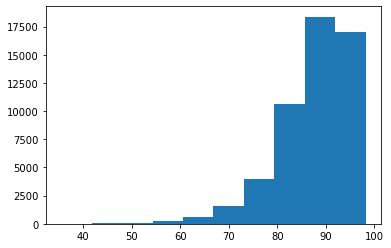

In [58]:
plt.hist(predictions_train)

(array([8.0000e+00, 2.5000e+01, 9.4000e+01, 2.8400e+02, 6.3400e+02,
        1.5210e+03, 3.5600e+03, 8.3930e+03, 1.6679e+04, 2.1337e+04]),
 array([ 20.,  28.,  36.,  44.,  52.,  60.,  68.,  76.,  84.,  92., 100.]),
 <BarContainer object of 10 artists>)

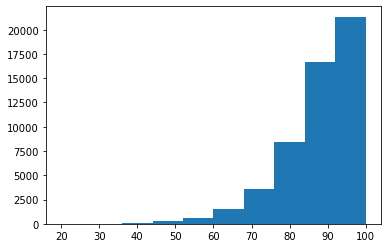

In [59]:
plt.hist(train[y_variable])

In [61]:
train[train[y_variable]>90]

,tract_geoid,All_Provider_Count,MaxAdDown,MaxAdUp,Wired_Provider_Count,Satellite_Provider_Count,Fixed_Wireless_Provider_Count,All_Provider_Count_25,All_Provider_Count_100,Fixed_Wireless_Provider_Count_25,...,pct_pop_income_lt_50k,pct_pop_income_lt_30k,pct_pop_income_gt_100k,log_median_income,pct_ages_gt_50,pct_ages_lt_9,interaction_computer_internet,interaction_low_income_internet,interaction_high_income_internet,interaction_white_internet
count,2.662300e+04,26623.000000,26623.000000,26623.000000,26623.00000,26623.000000,26623.000000,26623.000000,26623.000000,26623.000000,...,26623.000000,26623.000000,26623.000000,26623.000000,26623.000000,26623.000000,26623.000000,26623.000000,26623.000000,26623.000000
mean,2.762232e+10,10.800436,973.186155,641.108327,5.70856,3.995192,1.264283,5.141532,3.103933,0.671637,...,32.237124,18.191149,38.528918,11.261889,38.233755,11.161602,8080.618607,2704.828683,3461.683276,6262.566082
std,1.524906e+10,3.213234,101.738732,428.366985,2.83519,0.070784,1.427913,1.464281,1.221404,0.954086,...,15.517285,11.426083,18.285813,0.430020,10.547668,3.799372,1193.335886,1107.591789,1828.141722,2116.746328
min,1.001020e+09,4.000000,35.000000,3.000000,1.00000,2.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.094480,0.490614,0.000000,319.135045,0.000000,0.000000,0.000000
25%,1.500301e+10,9.000000,987.000000,100.000000,4.00000,4.000000,0.000000,4.000000,2.000000,0.000000,...,20.327139,10.109154,23.974366,10.994051,32.134914,8.861820,7358.432729,1868.466528,1976.911427,5321.900205
50%,2.700745e+10,10.000000,1000.000000,880.000000,5.00000,4.000000,1.000000,5.000000,3.000000,0.000000,...,30.026572,15.690867,37.185930,11.269056,38.475212,11.106856,8275.633771,2622.235891,3268.709728,6904.348321
75%,3.908521e+10,12.000000,1000.000000,1000.000000,7.00000,4.000000,2.000000,6.000000,4.000000,1.000000,...,41.867305,23.526952,51.951102,11.547887,44.111074,13.361194,8998.994465,3442.286250,4783.302622,7784.879465
max,5.604198e+10,38.000000,1000.000000,1000.000000,29.00000,4.000000,10.000000,16.000000,11.000000,7.000000,...,95.052632,86.231156,95.801527,12.429220,99.210526,43.323952,10000.000000,8358.300596,9458.267778,9666.862170


## random forest

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [96]:
y_train = train[y_variable]
X_train = train.drop(columns=[y_variable])

y_test = test[y_variable]
X_test = test.drop(columns=[y_variable])

In [97]:
regr = RandomForestRegressor(max_depth=10, random_state=0)

In [98]:
regr.fit(X_train[all_vars], y_train)

predictions_train = regr.predict(train[all_vars])

print("R^2 train: ",regr.score(train[all_vars], train[y_variable]))
print("MSE train: ", mean_squared_error(train[y_variable], predictions_train))
print("RMSE train: ", mean_squared_error(train[y_variable], predictions_train)**.5)

R^2 train:  0.7127795397951079
MSE train:  27.319015644663484
RMSE train:  5.226759574025142


In [99]:
predictions_test = regr.predict(test[all_vars])
print("R^2 test: ",regr.score(test[all_vars], test[y_variable]))
print("MSE test: ", mean_squared_error(test[y_variable], predictions_test))
print("RMSE test: ", mean_squared_error(test[y_variable], predictions_test)**.5)

R^2 test:  0.6189362551269902
MSE test:  36.234679800872684
RMSE test:  6.019524881655751


In [100]:
regr.n_features_in_

24

In [104]:
regr.feature_importances_

array([0.019585  , 0.00673392, 0.01896283, 0.003399  , 0.00231294,
       0.01479682, 0.03189055, 0.00583861, 0.0064152 , 0.04654548,
       0.4043445 , 0.00556714, 0.01252766, 0.24288548, 0.0071102 ,
       0.02649614, 0.00892565, 0.02973795, 0.02550069, 0.0088353 ,
       0.01119851, 0.02445672, 0.01133262, 0.02460111])

In [103]:
np.array(all_vars)[regr.feature_importances_>.1]

array(['interaction_high_income_internet', 'pct_hisp_latino'],
      dtype='<U34')

In [80]:
all_vars = float_vars

In [79]:
float_vars = train.dtypes[train.dtypes!=object].index.to_list()

for i in ['tract_geoid', 'pct_health_ins_children',
 'pct_health_ins_19_64',
 'pct_health_ins_65+', 'state',
 'county',
 'tract', 'em']:
    float_vars.remove(i)
    
float_vars

['All_Provider_Count',
 'MaxAdDown',
 'MaxAdUp',
 'Wired_Provider_Count',
 'Satellite_Provider_Count',
 'Fixed_Wireless_Provider_Count',
 'All_Provider_Count_25',
 'All_Provider_Count_100',
 'Fixed_Wireless_Provider_Count_25',
 'Wired_Provider_Count_25',
 'Satellite_Provider_Count_25',
 'Fixed_Wireless_Provider_Count_100',
 'Wired_Provider_Count_100',
 'Satellite_Provider_Count_100',
 'median_age_overall',
 'median_age_male',
 'median_age_female',
 'employment_rate',
 'median_income',
 'total_households',
 'ave_household_size',
 'ave_family_size',
 'total_population',
 'median_house_value',
 'pct_white',
 'pct_hisp_latino',
 'pct_black',
 'pct_native',
 'pct_asian',
 'pct_hi_pi',
 'pct_other_race',
 'pct_two+_race',
 'pct_rent_burdened',
 'poverty_rate',
 'pct_pop_bachelors+',
 'pct_pop_hs+',
 'pct_internet',
 'pct_internet_dial_up',
 'pct_internet_broadband_any_type',
 'pct_internet_cellular',
 'pct_only_cellular',
 'pct_internet_broadband_fiber',
 'pct_internet_broadband_satellite',


## XGBoost

In [67]:
import xgboost as xgb